In [2]:
from multiprocessing import freeze_support

import torch
from torch import nn
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader, Sampler
from torchvision import datasets
from torchvision.transforms import transforms
from torch.optim import Adam
import torch.functional as F
import matplotlib.pyplot as plt
import numpy as np
import PIL
from pathlib import Path

num_classes = 5
batch_size = 126
num_of_workers = 8

DATA_PATH_TRAIN = Path('dataset/training_set')
DATA_PATH_TEST = Path('dataset/test_set')

trans = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor()
#     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ])

trans_test = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor()
#     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ])

train_dataset = datasets.ImageFolder(root=DATA_PATH_TRAIN, transform=trans)
train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True, num_workers=num_of_workers)

test_dataset = datasets.ImageFolder(root=DATA_PATH_TEST, transform=trans_test)
test_loader = DataLoader(dataset=test_dataset, shuffle=True, num_workers=num_of_workers)

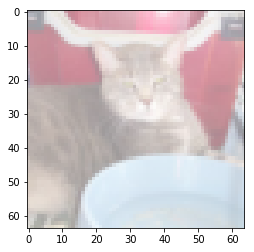

tensor([0])


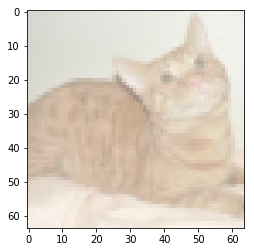

tensor([0])


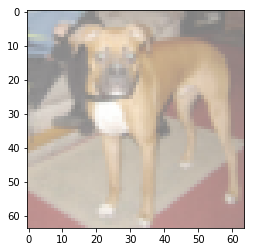

tensor([1])


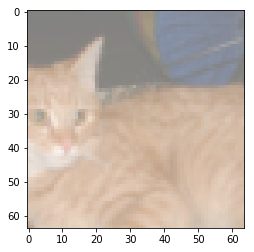

tensor([0])


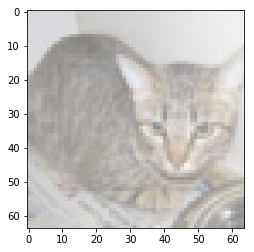

tensor([0])


In [17]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    #npimg = img.numpy()
    plt.imshow(np.transpose(img[0].numpy(), (1, 2, 0)))
    plt.show()
dataiter = iter(test_loader)
for i in range(5):
    images, labels = dataiter.next()

    # show images
    imshow(images)
    print(labels)

In [4]:
torch.cuda.set_device(0)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # ouput = (input -  kernel + 2*padding)/ stride + 1
        self.layer1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7, stride = 1, padding = 2)
                            # (64 - 7 + 2*2)/1 + 1 = 62
        self.layer2 = nn.BatchNorm2d(16)
        self.layer3 = nn.ReLU()
        self.layer4 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
                            # (62 - 2 + 0)/2 + 1 = 31
                                  
        self.layer5 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 2, padding = 0)
                            # (31 - 5 + 0)/2 + 1  = 14
        self.layer6 = nn.BatchNorm2d(32)
        self.layer7 = nn.ReLU()
        self.layer8 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
                            # (14 - 2 + 0)/2 + 1 = 7
                            
        self.fc1 = nn.Linear(32*7*7, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)
                        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

def init_normal(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)

    # use the modules apply function to recursively apply the initialization

net = Net()
net.cuda()
net.apply(init_normal)
print(net)

Net(
  (layer1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
  (layer2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): ReLU()
  (layer4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer5): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (layer6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer7): ReLU()
  (layer8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3, betas=(0.9, 0.999))

In [7]:
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

0
GeForce GTX 1050 Ti


In [8]:
device = torch.device('cuda:0')

In [9]:
32*256

8192

In [10]:
j = 0
num_epochs = 5
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      
        ## Pytorch has an easy method to convert data format to be compatible between CPU and GPU.
        # Convert the data vectors to the "device" type
        images = images.cuda()
        labels = labels.cuda()
        
        # Forward pass
        # Note how the output is extracted from the network in the line below.
        outputs = net(images)
        loss = loss_fn(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(epoch, i, loss.item())
        
        j += 1

0 0 0.9964927434921265
0 1 10.05224609375
0 2 5.406643390655518
0 3 1.4245506525039673
0 4 3.306192398071289
0 5 2.3143694400787354
0 6 1.0183074474334717
0 7 1.2887680530548096
0 8 1.8231779336929321
0 9 1.4648336172103882
0 10 0.8120667934417725
0 11 0.9387709498405457
0 12 1.1914247274398804
0 13 1.113139271736145
0 14 0.9223169684410095
0 15 0.7428348064422607
0 16 0.8398419618606567
0 17 0.9284200668334961
0 18 0.9194929599761963
0 19 0.8124902844429016
0 20 0.6826713681221008
0 21 0.7755194306373596
0 22 0.8740707635879517
0 23 0.8585314154624939
0 24 0.7189176678657532
0 25 0.6830864548683167
0 26 0.6633390188217163
0 27 0.7363572716712952
0 28 0.6466201543807983
0 29 0.6818891763687134
0 30 0.6846843361854553
0 31 0.7143352031707764
1 0 0.6780316233634949
1 1 0.6407199501991272
1 2 0.716844379901886
1 3 0.6743220090866089
1 4 0.6677823066711426
1 5 0.6336370706558228
1 6 0.6500720381736755
1 7 0.6453958749771118
1 8 0.6686140298843384
1 9 0.6383548378944397
1 10 0.6481388211250

In [11]:
test_acc = 0.0
j = 0
for i, (images, labels) in enumerate(test_loader):

    images = Variable(images.cuda())
    labels = Variable(labels.cuda())

        # Predict classes using images from the test set
    outputs = net(images)
    _, prediction = torch.max(outputs.data, 1)

    test_acc += torch.sum(prediction == labels.data).float()

    j += 1

    

In [12]:
j

2000

In [13]:
print(test_acc)

tensor(1336., device='cuda:0')


In [14]:
# it = iter(test_loader)
# labels, images = it.next()
# imshow(images)

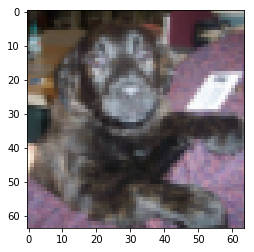

tensor([0], device='cuda:0') tensor([1])


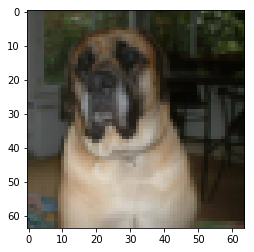

tensor([0], device='cuda:0') tensor([1])


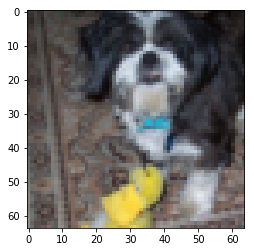

tensor([1], device='cuda:0') tensor([1])


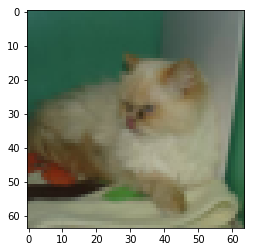

tensor([0], device='cuda:0') tensor([0])


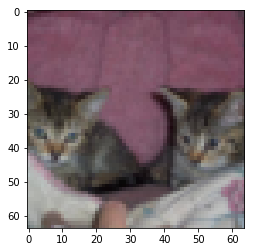

tensor([0], device='cuda:0') tensor([0])


In [15]:
def imshow(img):
 # unnormalize
    #npimg = img.numpy()
    plt.imshow(np.transpose(img[0].numpy(), (1, 2, 0)))
    plt.show()
dataiter = iter(test_loader)
for i in range(5):
    images, labels = dataiter.next()
    net.eval()
    imshow(images)
    outputs = net(images.cuda())
    _, predicted = torch.max(outputs.data, 1)
    print(predicted, labels)

In [20]:
for i, (img, lab) in enumerate(test_loader):

tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)


tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)


tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)


In [21]:
lab

tensor([0])